In [4]:
import os
import sys
sys.path.append('/home/yang_liu/python_workspace/3DGS')

import yaml
import torch
import torchvision
import wandb
import time
import inspect
import imageio
import numpy as np
import pynvml
import matplotlib.pyplot as plt
from tqdm import tqdm
from arguments import GroupParams
from scene import LargeScene
from os import makedirs
from gaussian_renderer import render_lod
from utils.general_utils import safe_state
from utils.large_utils import which_block, block_filtering
from argparse import ArgumentParser
from arguments import ModelParams, PipelineParams, get_combined_args
from gaussian_renderer import GaussianModel
from torch.utils.data import DataLoader
from utils.camera_utils import loadCamV2

In [2]:
class BlockedGaussian:

    gaussians : GaussianModel

    def __init__(self, gaussians, lp, range=[0, 1], scale=1.0, compute_cov3D_python=False):
        self.cell_corners = []
        self.xyz = None
        self.feats = None
        self.max_sh_degree = lp.sh_degree
        self.device = gaussians.get_xyz.device
        self.compute_cov3D_python = compute_cov3D_python
        self.cell_ids = torch.zeros(gaussians.get_opacity.shape[0], dtype=torch.long, device=self.device)
        self.mask = torch.zeros(gaussians.get_opacity.shape[0], dtype=torch.bool, device=self.device)

        self.block_dim = lp.block_dim
        self.num_cell = lp.block_dim[0] * lp.block_dim[1] * lp.block_dim[2]
        self.aabb = lp.aabb
        self.scale = scale
        self.range = range

        self.cell_divider(gaussians)
        self.cell_corners = torch.stack(self.cell_corners, dim=0)

    def cell_divider(self, gaussians, n=4):
        with torch.no_grad():
            if self.compute_cov3D_python:
                geometry = gaussians.get_covariance(self.scale).to(self.device)
            else:
                geometry = torch.cat([gaussians.get_scaling,
                                      gaussians.get_rotation], dim=1)
            self.xyz = gaussians.get_xyz
            self.feats = torch.cat([gaussians.get_opacity,  
                                    gaussians.get_features.reshape(geometry.shape[0], -1),
                                    geometry], dim=1).half()
            
            for cell_idx in range(self.num_cell):
                cell_mask = block_filtering(cell_idx, self.xyz, self.aabb, self.block_dim, self.scale)
                self.cell_ids[cell_mask] = cell_idx
                # MAD to eliminate influence of outsiders
                xyz_median = torch.median(self.xyz[cell_mask], dim=0)[0]
                delta_median = torch.median(torch.abs(self.xyz[cell_mask] - xyz_median), dim=0)[0]
                xyz_min = xyz_median - n * delta_median
                xyz_min = torch.max(xyz_min, torch.min(self.xyz[cell_mask], dim=0)[0])
                xyz_max = xyz_median + n * delta_median
                xyz_max = torch.min(xyz_max, torch.max(self.xyz[cell_mask], dim=0)[0])
                corners = torch.tensor([[xyz_min[0], xyz_min[1], xyz_min[2]],
                                       [xyz_min[0], xyz_min[1], xyz_max[2]],
                                       [xyz_min[0], xyz_max[1], xyz_min[2]],
                                       [xyz_min[0], xyz_max[1], xyz_max[2]],
                                       [xyz_max[0], xyz_min[1], xyz_min[2]],
                                       [xyz_max[0], xyz_min[1], xyz_max[2]],
                                       [xyz_max[0], xyz_max[1], xyz_min[2]],
                                       [xyz_max[0], xyz_max[1], xyz_max[2]]], device=self.xyz.device)
                self.cell_corners.append(corners)
    
    def get_feats(self, indices, distances):
        out_xyz = torch.tensor([], device=self.device, dtype=self.xyz.dtype)
        out_feats = torch.tensor([], device=self.device, dtype=self.feats.dtype)
        block_mask = (distances >= self.range[0]) & (distances < self.range[1])
        if block_mask.sum() > 0:
            self.mask = torch.isin(self.cell_ids, indices[block_mask].to(self.device))
            out_xyz = self.xyz[self.mask]
            out_feats = self.feats[self.mask]
        return out_xyz, out_feats

    def get_feats_ptwise(self, viewpoint_cam):
        out_xyz = torch.tensor([], device=self.device, dtype=self.xyz.dtype)
        out_feats = torch.tensor([], device=self.device, dtype=self.feats.dtype)

        homo_xyz = torch.cat([self.xyz, torch.ones_like(self.xyz[..., [0]])], dim=-1)
        cam_center = viewpoint_cam.camera_center
        viewmatrix = viewpoint_cam.world_view_transform
        xyz_cam = homo_xyz @ viewmatrix
        self.mask = (xyz_cam[..., 2] > 0.2)
        if self.mask.sum() == 0:
            return out_xyz, out_feats

        distances = torch.norm(self.xyz - cam_center[None, :3], dim=-1)
        self.mask &= (distances >= self.range[0]) & (distances < self.range[1])
        if self.mask.sum() > 0:
            out_xyz = self.xyz[self.mask]
            out_feats = self.feats[self.mask]
        return out_xyz, out_feats

def load_gaussians(cfg, config_name, iteration=30_000, load_vq=False, device='cuda', source_path='data/matrix_city/aerial/test/block_all_test'):
    
    lp, op, pp = parse_cfg(cfg)
    setattr(lp, 'config_path', cfg)
    lp.source_path = source_path
    lp.model_path = os.path.join("../output/", config_name)

    modules = __import__('scene')
    
    with torch.no_grad():
        if 'apply_voxelize' in lp.model_config['kwargs'].keys():
            lp.model_config['kwargs']['apply_voxelize'] = False
        gaussians = getattr(modules, lp.model_config['name'])(lp.sh_degree, device=device, **lp.model_config['kwargs'])
        scene = LargeScene(lp, gaussians, load_iteration=iteration, load_vq=load_vq, shuffle=False)
        print(f'Init {config_name} with {len(gaussians.get_opacity)} points\n')

    return gaussians, scene

def parse_cfg(cfg):
    lp = GroupParams()
    op = GroupParams()
    pp = GroupParams()

    for arg in cfg['model_params'].items():
        setattr(lp, arg[0], arg[1])
    
    for arg in cfg['optim_params'].items():
        setattr(op, arg[0], arg[1]) 

    for arg in cfg['pipeline_params'].items():
        setattr(pp, arg[0], arg[1])
    
    return lp, op, pp

In [3]:
load_vq = True
iteration = 30_000
custom_test = '../data/matrix_city/aerial/test/block_all_test'
if load_vq:
    iteration = None

config = "../config/block_mc_aerial_block_all_lr_c36_loss_5_lod.yaml"
model_path = os.path.join('../output', os.path.basename(config).split('.')[0])
with open(config) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    lp, op, pp = parse_cfg(cfg)
    setattr(lp, 'config_path', config)
    if lp.model_path == '':
        lp.model_path = model_path

assert len(lp.lod_configs)-1 == len(lp.dist_threshold)
lp.dist_threshold = [0] + lp.dist_threshold + [1e6]

with torch.no_grad():
    lod_gs_list = []
    for i in range(len(lp.lod_configs)):
        config = os.path.join("..", lp.lod_configs[i])
        config_name = os.path.splitext(os.path.basename(config))[0]
        with open(config) as f:
            cfg = yaml.load(f, Loader=yaml.FullLoader)
        lod_gs, scene = load_gaussians(cfg, config_name, iteration, load_vq, source_path=custom_test)
        lod_gs = BlockedGaussian(lod_gs, lp, range=[lp.dist_threshold[i], lp.dist_threshold[i+1]], compute_cov3D_python=pp.compute_cov3D_python)
        lod_gs_list.append(lod_gs)

    if custom_test:
        lp.source_path = custom_test
        filename = os.path.basename(lp.source_path)

    bg_color = [1,1,1] if lp.white_background else [0, 0, 0]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
    
    if custom_test:
        views = scene.getTrainCameras() + scene.getTestCameras()

Reading camera 741/741
Init block_mc_aerial_block_all_lr_c36_loss_5_50_lr64_vq with 11782801 points



/home/yang_liu/python_workspace/3DGS/utils/large_utils.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xyz_tensor = torch.tensor(xyz_org)


Reading camera 741/741
Init block_mc_aerial_block_all_lr_c36_loss_5_66_lr64_vq with 8012304 points

Reading camera 741/741
Init block_mc_aerial_block_all_lr_c36_loss_5_75_lr64_vq with 5891401 points



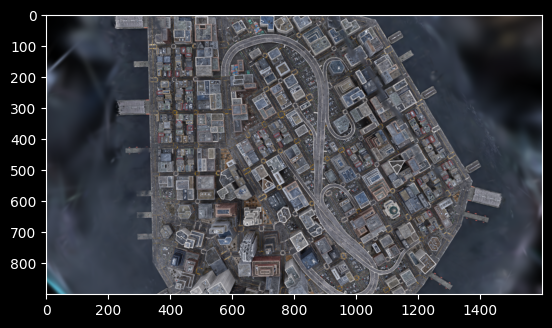

In [7]:
video_path = os.path.join(model_path, config_name, "ours_lod_video")
makedirs(video_path, exist_ok=True)

idx = 481
pitch = -180.0
duration_list = []
frames = []

# for height in tqdm(range(500, 2500, 50)):

viewpoint_cam = loadCamV2(lp, idx, views[idx], 1.0, pitch, float(2500)/100)

# gpu_tracker.track() 
start = time.time()
img = render_lod(viewpoint_cam, lod_gs_list, pp, background)["render"]
img = (img * 255).clamp(0, 255).to(torch.uint8).permute(1, 2, 0).cpu().numpy()
end = time.time()
# frames.append(img)
# duration_list.append(end - start)

plt.imshow(img)

In [21]:
imageio.mimsave(os.path.join(video_path, f"video.gif"), frames, duration=duration_list)
print(f'Saved to {video_path}')